In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from keras import Sequential
from keras.models import load_model
# from models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

Using TensorFlow backend.


In [2]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

In [3]:
rawdf = pd.read_csv('dataFakeFull.csv')
#rawdf.head()
salary_df = rawdf[['muc_tieu_dat_duoc', 'chat_luong_du_an', 'OT', 'du_an', 'Luong']]
salary_df.head(50)

,muc_tieu_dat_duoc,chat_luong_du_an,OT,du_an,Luong
0,90,1,2,1,58.800
1,90,1,1,1,30.450
2,70,1,0,1,8.400
3,90,1,1,5,14.700
4,100,1,5,4,17.850
5,90,1,5,0,16.800
6,80,0,5,0,8.400
7,70,1,4,1,11.550
8,70,0,5,5,15.750
9,100,4,2,5,7.350


In [4]:
# Preprocessing data
#df = rawdf.copy()
df = salary_df.copy()

# Batch normalization
ss = StandardScaler()
scale_features = ['muc_tieu_dat_duoc']
df[scale_features] = ss.fit_transform(df[scale_features])

# Convert categorical data to one-hot representation
categorical_features = ['muc_tieu_dat_duoc', 'chat_luong_du_an', 'OT', 'du_an']
df_cat = pd.get_dummies(df[categorical_features]) # get_dummies giống với one-hot-encoder
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,Luong,muc_tieu_dat_duoc,chat_luong_du_an,OT,du_an
0,58.80,0.463029,1,2,1
1,30.45,0.463029,1,1,1
2,8.40,-1.320251,1,0,1
3,14.70,0.463029,1,1,5
4,17.85,1.354668,1,5,4


In [5]:
# Convert data from dataframe to numpy array
x_data = df.drop('Luong', axis=1).values
y_data = df['Luong'].values
print(x_data[0])
print(y_data[0])
# Split data train and test
x_train= []
x_test=[]
y_train=[]
y_test=[]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state=0)
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)
print("x_test.shape = ", x_test.shape)
print("y_test.shape = ", y_test.shape)

[0.46302856 1.         2.         1.        ]
58.8
x_train.shape =  (9000, 4)
y_train.shape =  (9000,)
x_test.shape =  (1000, 4)
y_test.shape =  (1000,)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 7200 samples, validate on 1800 samples
Epoch 1/30
7200/7200 [==============================] - 1s 79us/step - loss: 187.2791 - val_loss: 94.9737
Epoch 2/30
7200/7200 [==============================] - 0s 48us/step - loss: 95.2599 - val_loss: 78.8488
Epoch 3/30
7200/7200 [==============================] - 0s 55us/step - loss: 85.5820 - val_loss: 75.2394
Epoch 4/30
7200/7200 [==============================] - 0s 56us/step - loss: 83.6015 - val_loss: 74.1573
Epoch 5/30
7200/7200 [==============================] - 0s 68us/step - loss: 82.8972 - val_loss: 73.8869
Epoch 6/30
7200/7200 [==============================] - 0s 52us/step - loss: 82.4860 - val_loss: 73.6831
Epoch 7/30
7200/7200 [==============================] - ETA: 0s - loss: 81.16 - 0s 56us/step - loss: 82.2035 - val_loss: 74.1361
Epoch 8/30
7200/7200 [==============================] - 0s 45us/step - loss: 81.9878 - val_loss: 73.3522
Epoch

<Figure size 576x432 with 0 Axes>

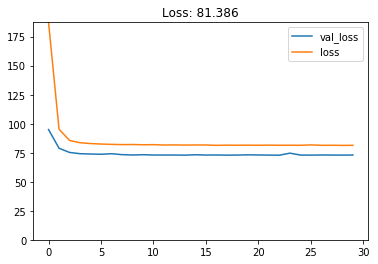

In [6]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(x_train.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

deep_history = deep_model.fit(x_train, y_train, epochs=30, validation_split=0.2)
plot_loss(deep_history)

In [7]:
# Save model
deep_model.save('LongTest.h5')

In [8]:
# Load model
deep_model = load_model('LongTest.h5')

In [9]:
# Predict
y_predict = []
y_predict = deep_model.predict(x_test)

In [10]:
# Reshape y_test về cùng hình dạng với y_predict
y_test = np.array([y_test]).T

In [11]:
for i in range(10):
    print("predict = ", y_predict[i])
    print("label = ", y_test[i])
    print('\n')

predict =  [15.912777]
label =  [9.45]


predict =  [15.21057]
label =  [14.7]


predict =  [14.464228]
label =  [14.7]


predict =  [16.430513]
label =  [15.75]


predict =  [16.000225]
label =  [6.3]


predict =  [15.603707]
label =  [5.25]


predict =  [15.091878]
label =  [4.2]


predict =  [15.632903]
label =  [21.]


predict =  [16.619864]
label =  [21.]


predict =  [15.628008]
label =  [19.95]




In [12]:
# Đánh giá độ chính xác với ngưỡng chênh < 1tr
accuracy = (abs(y_test - y_predict) <= 1.0).mean() * 100
print("Độ chính xác  = ", accuracy,"%")

Độ chính xác  =  9.5 %
